# First Prototype for generating a more sophisticated web app

import libs and load data

In [1]:
# local utilities
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.BTTools import filter_for
from utilities.BTTools import groupSpeechesByDiscussionTitle

# other stuff needed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import tqdm

import json

with open('../../data/speeches_20.jsonl', 'r', encoding='utf8') as fp:
    data = list(fp)
speeches_original = []
for line in data:
    speeches_original.append(json.loads(line))
    
speeches = speeches_original.copy()    

# Level I

## 1. Topic Model at the level of TOPs


### 1.1 Create Corpus

#### restructure data per TOP

In [2]:
groupedby_discussion = groupSpeechesByDiscussionTitle(speeches)
len(groupedby_discussion)

208

#### build corpus for scikit learn methods

In [3]:
corpus = []
for top in groupedby_discussion.values():
    #print(grouped[top])
    aggregate= []
    for ele in top:
        aggregate.append(ele['text'])
    corpus.append(' '.join(aggregate))

len(corpus)


208

#### optional: preprocessing with spacy

In [5]:

import spacy
nlp = spacy.load('de') #load spacy model


In [6]:

def corpus_by_POS(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.pos_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 


In [7]:
consider = ['NOUN']
        
corpus_nouns = corpus_by_POS(corpus,consider)        
len(corpus_nouns)

100%|██████████| 208/208 [03:11<00:00,  1.09it/s]


208

In [7]:
corpus = corpus_nouns
corpus[0]

'Kraft Wohle Volk Nutzen Schaden Grundgesetz Gesetz Bund Pflicht Gerechtigkeit'

### 1.2 Topic Model

#### vectorize data

In [8]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.8, min_df=0.01,lowercase = False)
tf_idf_matrix  = vectorizer_tfidf.fit_transform(corpus)
feature_names = vectorizer_tfidf.get_feature_names()
vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
tf_matrix = vectorizer_tf.fit_transform(corpus)

tf_idf_matrix

<208x7520 sparse matrix of type '<class 'numpy.float64'>'
	with 97685 stored elements in Compressed Sparse Row format>

#### compute topic model

#### <font color='red'>From here on I now use a dict structure!</font>

In [25]:
# Use NMF to look for 15 topics
n_topics = 10
model = NMF(n_components=n_topics)
model.fit(tf_idf_matrix)
#model.fit(tf_matrix)

# Print the top 10 words
n_words = 100
#n_words_features = 100

topic_names = []
topic_words = []
# new: store in dict
topics = []  
for topic_idx, topic in enumerate(model.components_):
    t_words = [feature_names[i] for i in topic.argsort()[-n_words:]][::-1]
    t_words_string = ' '.join(t_words[:10])
    topic_names.append(f"topic_{'_'.join(t_words[:3])}") 
    #topic_list_ext.append(top_features)
    
#    top_n = [feature_names[i]
#             for i in topic.argsort()
#             [-n_words_features:]][::-1]
    topic_words.append(t_words)
    topic_dict = { 'name' : f"topic_{'_'.join(t_words[:3])}",
                   'words' : t_words,
                   'tops' : []  
                    }
    topics.append(topic_dict)
    print(f"Topic {topic_idx}: {t_words_string}")

# for empty data (speeches without text)
topic_dict = { 'name' : 'rest',
               'words' : [],
               'tops' : []  
                }
topics.append(topic_dict)    
    
topic2word = model.components_   
#topics

Topic 0: Energie Gas Ausbau Klimaschutz Strom Energieversorgung Antrag Energiewende EEG Erneuerbaren
Topic 1: Krieg Putin Russland Waffe Bundeskanzler Sanktion Friede Bundeswehr Präsident Waffenlieferungen
Topic 2: Impfpflicht Impfung Pandemie Pflege Variante Impfstoff Impfungen Impfen Virus Welle
Topic 3: Mandat Soldat Mission Soldatinnen Bundeswehr Einsatz Operation Südsudan Region Nation
Topic 4: Euro Milliarde Haushalt Investition Nachtragshaushalt Pandemie Wirtschaft Krise Sondervermögen Schuldenbremse
Topic 5: Landwirt Landwirtschaft Hunger Ernährung Lebensmittel Bauer Fläche Million Betrieb Agrarpolitik
Topic 6: Kind Kommune Ganztagsbetreuung Schule Bund Familie Bildung Jugendliche Registrierung Ministerin
Topic 7: Inflation Euro Entlastung Antrag Einkommen Preis Bürger Maßnahme Progression Rentner
Topic 8: Antrag Opfer Demokratie Anschlag Sicherheitsbehörden Rechtsextremismus Extremismus Rechtsstaat Straftat Kriminalität
Topic 9: Gesetz Gesetzentwurf Unternehmen Maßnahme Sankti

In [26]:
len(topics)

11

#### Word Clouds for Topic

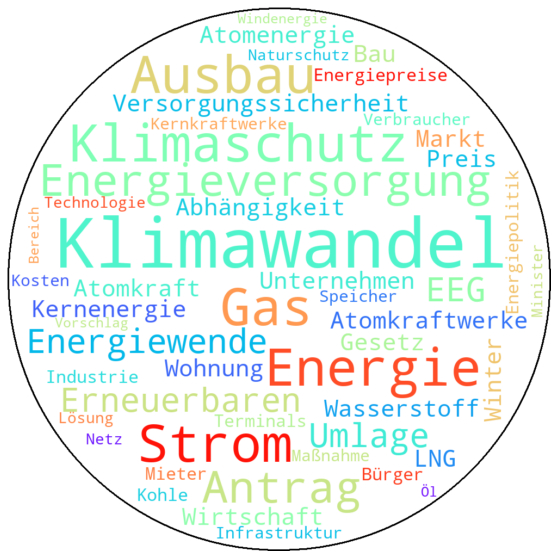

In [28]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud

mask = np.array(Image.open("circle.png"))

# parameters:

wordcloud = WordCloud(background_color='white', max_words=50, mask=mask, contour_color='#000000', contour_width=3, colormap='rainbow').generate(" ".join(topic_words[0]))

# create image as circle

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# presentate:

plt.show()


# generate PNG for all topics
for tx,topic in enumerate(topics):
    if topic['name'] == 'rest':
        pass
    else:
        wordcloud = WordCloud(background_color='white', max_words=50, mask=mask, contour_color='#000000', contour_width=3, colormap='rainbow').generate(" ".join(topic['words']))
        wordcloud.to_file(f"wordclouds/wordcloud_{tx}.png")


#### document topic probabilities

In [29]:
print(tf_matrix.shape)
print(topic2word.shape)
doc2topic = (tf_matrix * topic2word.T)
print(doc2topic.shape)

(208, 7520)
(10, 7520)
(208, 10)


In [ ]:
topic2word.T[0]

#### find max contributions for words and docs

In [30]:
feature_topic_num = []
feature_topic_name = []
for wx,word in enumerate(feature_names):
    if topic2word.T[wx].max() > 0:
        topic_num = topic2word.T[wx].argmax()
        topic_name = topic_names[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    feature_topic_num.append(topic_num)
    feature_topic_name.append(topic_name)
#feature_topic_num

top_topic_num = []
top_topic_name = []
for tx,top in enumerate(groupedby_discussion):
    if doc2topic[tx].max() > 0:
        topic_num = doc2topic[tx].argmax()
        topic_name = topic_names[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    top_topic_num.append(topic_num)
    top_topic_name.append(topic_name)
        
    # update topic dict   
    topics[topic_num]['tops'].append(top)

    
#feature_topic_num

In [32]:
#topics

## 1.3 Generate Topic Network (I take now Julians Version)

In [53]:
from sklearn.metrics.pairwise import cosine_similarity

def get_topic2_topic(tm):
    normalized_matrix = normalize(tm.components_, axis=1, norm='l1')
    print(f'normalized_matrix: {normalized_matrix.shape}')

    topic_to_topic = cosine_similarity(normalized_matrix)
    print(f'topic2topic: {topic_to_topic.shape}')

    return topic_to_topic

def create_topic2topic_graph(t2t, extended_topic_list):
    nodes = []
    count = 1

    for i, topic in enumerate(topics):
        if topic['name'] == 'rest':
            pass
        else:
            nodes.append({
                'id': count,
                'name': topic['name'],
                'nTops': len(topic['tops'])+1
            })
            count += 1

    graph = {
        'directed': False,
        'graph': 'semant_graph',
        'links': [],
        'nodes': nodes
    }

    for i, node_i in enumerate(graph['nodes']):
        for j, node_j in enumerate(graph['nodes']):
            if i < j:
                source = node_i['id']
                target = node_j['id']
                weight = t2t[i, j]
                if weight > 0.15:
                    link = {
                        'source': source,
                        'target': target,
                        'weight': weight
                    }
                    graph['links'].append(link)

    return graph

def get_graph_template(graph, properties):
    node_label = properties['nodelabel']
    node_coloring = properties['nodecoloring']
    node_size = properties['nodesize']

    lv = '//' if properties['edgevisibility'] else ''
    parts = '//' if not properties['particles'] else ''
    dm = '//' if not properties['darkmode'] else ''

    d3graph = {
        'nodes': graph['nodes'],
        'links': graph['links']
    }

    htmlcode = f"""<head>
        <style>
            body {{margin: 0;}}
            h3 {{text-align: center;}}
            .center {{
              display: block;
              margin-left: auto;
              margin-right: auto;
            }}
        </style>
        <script src="https://unpkg.com/force-graph"></script>
        <meta charset="UTF-8">
    </head>
    <body>
    <img src="Logo.png" height="150" width="300" class="center">
    <h3>DebSearch ist eine statistische Website, welche die aktuelle Legislaturperiode</h3>
    <h3>in verschiedenen Kategorieren auswertet und visualisiert.</h3>
    <div id="graph"></div>
    <script>
        var data = {d3graph};
        const elem = document.getElementById('graph');
        const Graph = ForceGraph()(elem)
            .graphData(data)
            .nodeLabel('{node_label}')
            .nodeRelSize(1)
            .nodeVal('{node_size}')
            .nodeAutoColorBy('{node_coloring}')
            {dm}.backgroundColor('#000000')
            {dm}.linkColor(() => 'rgba(255,255,255,0.2)')
            {lv}.linkVisibility('false')
            {parts}.linkDirectionalParticles(2)
            {parts}.linkDirectionalParticleWidth(1.4)
            //.onNodeClick (node => {{window.open('./TOPnets/TOPnet4topic0.html', '_blank')}})
            .onNodeClick (node => {{window.open(`./TOPnets/TOPnet4topic${{node.id-1}}.html`, '_blank')}})
            //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
            .onNodeRightClick(node => {{
                // Center/zoom on node
                Graph.centerAt(node.x, node.y, 1000);
                Graph.zoom(4, 2000);
            }});
    </script>
    </body>
    """

    return { 'graph': htmlcode }

In [54]:
topic2topic = get_topic2_topic(model)

t2t_graph = create_topic2topic_graph(topic2topic, topic_list)

print(f"got a graph with {len(t2t_graph['nodes'])} nodes.")
print('the first node:')
print(t2t_graph['nodes'][0])


properties = {
    'nodecoloring':'name',
    'nodelabel': 'name',
    'nodesize': 'nTops',
    "darkmode": False,
    "edgevisibility": True,
    "particles": False
}

html_graph = get_graph_template(t2t_graph, properties)

with open(f'./topic_network.html', 'w') as f:
    f.write(html_graph['graph'])

normalized_matrix: (10, 7520)
topic2topic: (10, 10)
got a graph with 10 nodes.
the first node:
{'id': 1, 'name': 'topic_Energie_Gas_Ausbau', 'nTops': 98}


# Level II

## 2.1 Generate HTML page for single Topics



In [ ]:
corpus[0]

#### This should go to a function

In [16]:

topic_index = 0

for topic_index, topic_name in enumerate(topic_list):

    # select TOPs for max. relevant topic
    #topic_selection = []
    #for tx,top in enumerate(groupedby_discussion):
    #    if top_topic_num[tx] == topic_index:
    #        topic_selection.append(groupedby_discussion[top])
    #        #print(top)

    # Alternative using the corpus
    topic_selection = []
    top_indices = []
    top_names = []
    for tx,top in enumerate(corpus):
        if top_topic_num[tx] == topic_index:
            topic_selection.append(top)
            top_indices.append(tx)
            top_names.append(list(groupedby_discussion.keys())[tx])
            #print(top)
    
    print(f'Topic {topic_index} has {len(topic_selection)} TOPs')
    
    # remove words that are max. relevant for topic        
    topic_features = []
    for wx,word in enumerate(feature_names):
        if feature_topic_num[wx] != topic_index:
            topic_features.append(word)

    #len(topic_features)

    # compute semantic similarity for selection
    if len(topic_selection) == 0:
        print(f'Topic {topic_index} cannot be constructed')
    else:
        vectorizer_topic = TfidfVectorizer(vocabulary=topic_features,lowercase = False)
        tf_idf_matrix_topic  = vectorizer_topic.fit_transform(topic_selection)
        pairwise_similarity_topic = tf_idf_matrix_topic * tf_idf_matrix_topic.T 
        similarity_topic = pairwise_similarity_topic.toarray()

        print(similarity_topic.shape)


        # build network
        # nodes:
        nodes = []
        count = 1
        for tx,top_ix in enumerate(top_indices):
            node_dict = {
                'id' : count,
                'top' : top_ix,
                'date' : groupedby_discussion[ top_names[tx] ][0]['date'],
                'nReden' : len( groupedby_discussion[ top_names[tx] ] )
            }
            nodes.append(node_dict)
            count += 1

        # graph construct
        graph = {
            'directed': False,
            'graph': 'semant_graph',
            'links': [],
            'nodes': nodes,
        }   

        # edges:
        min_weight = 0.15
        for ix,nodeI in enumerate(graph['nodes']):
            for jx,nodeJ in enumerate(graph['nodes']):
                if ix < jx:
                    source = nodeI['id']
                    target = nodeJ['id']
                    weight = similarity_topic[ix,jx]
                    if weight > min_weight:
                        link_dict = {
                            'source':source,
                            'target':target,
                            'weight':weight       
                        }
                        graph['links'].append(link_dict)


        nn = len(graph['nodes'])
        ne = len(graph['links'])
        print( f"This graph has {nn} nodes and {ne} links.")


        # write to HTML

        data = graph
        d3graph = {"nodes": [], "links": []}
        d3graph["nodes"] = data["nodes"]
        d3graph["links"] = data["links"]

        htmlcode = f"""<head>
            <style> body {{margin: 0;}} </style>
            <script src="https://unpkg.com/force-graph"></script>
            <meta charset="UTF-8">
        </head>
        <body>
        <div id="graph"></div>
        <script>
            var data = {d3graph};
            const elem = document.getElementById('graph');
            const Graph = ForceGraph()(elem)
                .graphData(data)
                .nodeLabel('top')
                .nodeRelSize(1)
                .nodeVal('nReden')
                //.linkVisibility('true')
                //.onNodeClick (node => {{window.open(`wordnet.html`, '_blank')}})
                //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
                .onNodeRightClick(node => {{
                    // Center/zoom on node
                    Graph.centerAt(node.x, node.y, 1000);
                    Graph.zoom(4, 2000);
                }});
        </script>
        </body>
        """

        with open (f"./TOPnets/TOPnet4topic{topic_index}.html", "w") as f:
            f.write(htmlcode)

Topic 0 has 97 TOPs
(97, 97)
This graph has 97 nodes and 833 links.
Topic 1 has 22 TOPs
(22, 22)
This graph has 22 nodes and 52 links.
Topic 2 has 15 TOPs
(15, 15)
This graph has 15 nodes and 78 links.
Topic 3 has 0 TOPs
Topic 3 cannot be constructed
Topic 4 has 3 TOPs
(3, 3)
This graph has 3 nodes and 0 links.
Topic 5 has 2 TOPs
(2, 2)
This graph has 2 nodes and 1 links.
Topic 6 has 37 TOPs
(37, 37)
This graph has 37 nodes and 173 links.
Topic 7 has 5 TOPs
(5, 5)
This graph has 5 nodes and 6 links.
Topic 8 has 2 TOPs
(2, 2)
This graph has 2 nodes and 1 links.
Topic 9 has 18 TOPs
(18, 18)
This graph has 18 nodes and 29 links.


In [ ]:
#nodes

## 2.2 Tom's Arbeit zu den häufigsten Worten

In [56]:
selection = topics[0]['tops']
#selection

In [57]:
mydata=[]
for ele in selection:
    top=groupedby_discussion[ele]
    #print(top)
    for rede in top:
        #print(rede['text'])
        mydata.extend(rede['text'].split())

In [58]:
import collections
counter = collections.Counter(mydata).most_common()[:15]
counter

[('die', 22724),
 ('und', 21359),
 ('der', 18135),
 ('in', 12341),
 ('wir', 10522),
 ('das', 9359),
 ('ist', 8634),
 ('den', 7453),
 ('auch', 7423),
 ('Sie', 7204),
 ('zu', 7174),
 ('nicht', 7116),
 ('dass', 6883),
 ('für', 6567),
 ('es', 6004)]

## 2.3 Marcel's Arbeit zu den Kommentaren

In [80]:
# load data with comments

with open('../../data/speeches_20_withcomments.jsonl', 'r', encoding = 'utf8') as fp:
    data = list(fp)
speeches_wc = []
for line in data:
    speeches_wc.append(json.loads(line))

# group by discussion title    

groupedby_discussion_wc = groupSpeechesByDiscussionTitle(speeches_wc)
print(len(groupedby_discussion_wc))


selection = topics[0]['tops']
speeches_in_topic = []
for ele in selection:
    top=groupedby_discussion_wc[ele]
    #print(top)
    for rede in top:
        #print(rede['text'])
        speeches_in_topic.append(rede)

#speeches_in_topic

208


In [81]:
len(speeches_in_topic)

1226

In [65]:
import re

def groupSpeechesByParty(speeches):
    groupedSpeeches = {}
    for speech in speeches:
        tpo = speech['party']
        if tpo in groupedSpeeches:
            groupedSpeeches[tpo].append(speech)
        else:
            groupedSpeeches[tpo] = [speech]
    return groupedSpeeches

def clean_partyname(speeches):
    for speech in speeches:
        if 'BÜNDNIS\xa090/DIE GRÜNEN' in speech['party']:
            speech.update({'party': 'BÜNDNIS 90/DIE GRÜNEN'})

            
# filter: Kommentare extrahieren
def extract_comments(speeches):
    regex = "{(.*?)}" # hier die genaue Definition der Kommentare vom Parser <<< >
    comments = []
    modified_speeches = []
    for speech in speeches:
        text = speech['text']
        matches = re.findall(regex,text)
        speech['comments'] = matches
        modified_speeches.append(speech)
    return modified_speeches


# filter: comments per party with contain words and not contain words
def filter_with_complex_non_words(search_terms,non_words,speeches):
    filtered_speeches = []
    for speech in speeches:
        for comment in speech['comments']:
            if all([term in comment for term in search_terms]) and not any([term in comment for term in non_words]):
                filtered_speeches.append(speech)
                break
    return filtered_speeches
# Funktionsaufruf:  specific_and_non_search = filter_with_complex_non_words(['Beifall','CDU'],['Zuruf'],speeches_comments)
# Funktionsausgabe: print(specific_and_non_search[0])                               enthält AND enthält nicht
#                   print(len(specific_and_non_search))

            





In [82]:
#groupbyparty = groupSpeechesByParty(speeches_in_topic)
print(f'alle Reden: {len(speeches_in_topic)}') # Anzahl aller Reden
#for ele in groupbyparty:
#    print(len(groupbyparty[ele]))
# Überprüfung mit bspw.: len(groupbyparty['SPD'])

# Funktionsaufruf: speeches_comments = extract_comments(speeches)
speeches_comments = extract_comments(speeches_wc)
# Funktionsausgabe: print(speeches_comments[0]['comments'])
#                   print(speeches_comments[0]['party'])


specific_and_non_search = filter_with_complex_non_words(['DIE LINKE'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von Die Linke:             {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['SPD'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von SPD:                   {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['BÜNDNIS 90/DIE GRÜNEN'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von BÜNDNIS 90/DIE GRÜNEN: {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['CDU/CSU'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von CDU/CSU:               {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['FDP'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von FDP:                   {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['AfD'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von AfD:                   {len(specific_and_non_search)}')
specific_and_non_search = filter_with_complex_non_words(['fraktionslos'],[],speeches_in_topic)
print(f'Anzahl Kommentare mit Beteiligung von Fraktionslos:          {len(specific_and_non_search)}')

alle Reden: 1226
Anzahl Kommentare mit Beteiligung von Die Linke:             214
Anzahl Kommentare mit Beteiligung von SPD:                   1085
Anzahl Kommentare mit Beteiligung von BÜNDNIS 90/DIE GRÜNEN: 773
Anzahl Kommentare mit Beteiligung von CDU/CSU:               823
Anzahl Kommentare mit Beteiligung von FDP:                   1030
Anzahl Kommentare mit Beteiligung von AfD:                   637
Anzahl Kommentare mit Beteiligung von Fraktionslos:          11


## Additional Stuff

### X.1 Temporal Evolution

In [ ]:
def groupSpeechesByDate(speeches):
    groupedSpeeches = {}
    speeches.sort(key = lambda x:x['date'])
    for speech in speeches:
        top = speech['date']
        if top in groupedSpeeches:
            groupedSpeeches[top].append(speech)
        else:
            groupedSpeeches[top] = [speech]
    
    return groupedSpeeches


groupedby_date = groupSpeechesByDate(speeches)
len(groupedby_date)


#groupedby_date['2022-04-27']

In [ ]:
groupedby_date.keys()

In [ ]:
corpus_by_date = []
for docs in groupedby_date.values():
    #print(grouped[top])
    aggregate= []
    for ele in docs:
        aggregate.append(ele['text'])
    corpus_by_date.append(' '.join(aggregate))

len(corpus_by_date) 
#corpus_by_date[0]

In [ ]:
consider = set([x for xs in topic_words for x in xs])
#consider

In [ ]:

#consider = feature_names

consider = set([x for xs in topic_words for x in xs])

def corpus_by_Features(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.lemma_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 
     
corpus_by_date_features = corpus_by_Features(corpus_by_date,consider)        
len(corpus_by_date_features)

In [ ]:
#corpus_by_date_features[1]
feature_names.index('und')
#topic_words
len(consider)

In [ ]:
evo_vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
evo_tf_matrix = evo_vectorizer_tf.fit_transform(corpus_by_date_features)
print(evo_tf_matrix.shape)
print(topic2word.shape)

topic2word_norm = normalize(topic2word, norm='l1', axis=0, copy=True, return_norm=False)

time2topic = evo_tf_matrix.dot(topic2word_norm.T)
print(time2topic.shape)
print(time2topic.sum(axis=1))

In [ ]:
plt.figure(figsize=(10, 5))
#plt.plot(groupedby_date.keys(),time2topic,label = topic_list)
plt.stackplot(groupedby_date.keys(),time2topic.T)

plt.xticks(rotation=65, ha='right')
#plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.01, 1.01))
#locs, labels = xticks()
#xticks(locs,)
plt.show()